Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
from random import choices, seed, choice, random, sample
from sklearn.metrics.pairwise import cosine_similarity

import lab9_lib
import numpy as np
import copy
import matplotlib.pyplot as plt

In [259]:
fitness = lab9_lib.make_problem(5)
for n in range(10):
    ind = choices([0, 1], k=30)
    print(ind)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

[0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]
010101110110000110110111111001: 15.19%
[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
111111001111101011110011111111: 18.15%
[0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0]
010001101111001001101011100100: 50.00%
[1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
110110101010010101011111110110: 32.22%
[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
000010111101001110111110110000: 15.23%
[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]
011101001100110010000011110010: 15.59%
[0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]
011100100011001010111010011001: 15.56%
[1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]

# Ideas

## Tricks and ideas

- Save configurations + fitness in a dictionary to avoid repetitions
- Create a CNN+FC to, first extract the genome information (necessary spatial information) and then predict the associated fitness


## Island

- Generate K islands, evolve them independently and, each N mutations, let one individual from each travel to others (one individual can travel to multiple islands?). How to choose the individual?


## Mutation

- Change the bit with a given probability. How many bits to mutate?


## Save the best

- Elitism: copy the champion into the offsprings without modifications
- Valhalla: keep the best apart and, from time to time, put them back in the population


## Recombination

- Implement one cuts/two cuts/n cuts
- Do it choosing the idx through a Gaussian


## Parent selection (semi stochastic)

- Try roulette (linearized proportional to fitness, trouble with big populations)
- Try tournament (increase size to increase pressure)


## Survival selection (fully deterministic)

- Filter only the top K fittest individuals

# Our Solution

## V1.0

The simplest approach.

In [260]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    # Select top K fittest individuals and return N_OFFSPRINGS couple of individuals.
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))


def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child


# def two_cuts_xover(couple : tuple) -> list:
#     idx_1 = np.random.randint(1, len(couple[0]) - 2)
#     idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
#     return np.concatenate((couple[0][:idx_1], couple[1][idx_1:idx_2], couple[0][idx_2:]))

def two_cuts_xover(couple : tuple) -> list:
    idx_1 = np.random.randint(1, len(couple[0]) - 2)
    idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
    return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return two_cuts_xover(couple)

In [261]:
POP_SIZE = 10           # Number of parents
N_OFFSPRINGS = 30       # Number of children
N_GENERATIONS = 1500    # Number of generations
TOP_K = 10              # Number of parents from which generating the offsprings
SIZE = 100              # Size of the genome
P_MUTATION = 0.2        # Probability of a mutation

pop = []
for _ in range(POP_SIZE):
    pop.append(choices([0, 1], k=SIZE))

In [262]:
parents = roulette_selection(TOP_K, pop, [fitness(ind) for ind in pop])

for _ in range(N_GENERATIONS):
        
    # recombinated_offsprings = map(one_cut_xover, parents)
    recombinated_offsprings = map(uniform_xover, parents)
    mutated_offsprings = np.array(list(map(mutate_bit, recombinated_offsprings)))
    fit = np.array(list(map(fitness, mutated_offsprings)))
    survived = mutated_offsprings[np.argsort(fit)[-POP_SIZE:]]
    if (fit > 0.95).any():
        break

    parents = roulette_selection(TOP_K, survived, [fitness(ind) for ind in survived])
    print(_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [263]:
mutated_fitness = list(map(fitness, mutated_offsprings))
ordered_mutated = [_ for _, x in sorted(zip(mutated_offsprings, mutated_fitness), key=lambda pair: pair[1], reverse=True)]

for sur in ordered_mutated:
    print(f"{''.join(str(g) for g in sur)}: {fitness(sur):.2%}")

0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000100001001011010010100100010000110100001010000110000101001000010100001011010110000: 36.00%
0010110101101010000

## V1.5
Basic implementation of the Valhalla loading the champions at every epoch.

In [264]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    # Select top K fittest individuals and return N_OFFSPRINGS couple of individuals.
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))


def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child


# def two_cuts_xover(couple : tuple) -> list:
#     idx_1 = np.random.randint(1, len(couple[0]) - 2)
#     idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
#     return np.concatenate((couple[0][:idx_1], couple[1][idx_1:idx_2], couple[0][idx_2:]))

def two_cuts_xover(couple : tuple) -> list:
    idx_1 = np.random.randint(1, len(couple[0]) - 2)
    idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
    return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return two_cuts_xover(couple)

In [265]:
POP_SIZE = 50           # Number of parents
N_OFFSPRINGS = 150       # Number of children
N_GENERATIONS = 1500    # Number of generations
TOP_K = 20              # Number of parents from which generating the offsprings
EPOCH = 30              # Number of generation to reintroduce the best fitting
N_CHAMPIONS = 12        # Number of champions that will rest in the Valhalla
SIZE = 1000             # Size of the genome
P_MUTATION = 0.2        # Probability of a mutation        

fitness = lab9_lib.make_problem(5)

pop = []
for _ in range(POP_SIZE):
    pop.append(choices([0, 1], k=SIZE))

In [266]:
parents = roulette_selection(TOP_K, pop, [fitness(ind) for ind in pop])

# EPOCH // 10 is the number of N_CHAMPIONS that can be stored simultaneously. For example,
# if N_CHAMPIONS == 4, and EPOCH // 10 == 3 the valhalla can store up to 12 champions.
valhalla = np.empty(shape = ((EPOCH // 10) * N_CHAMPIONS, SIZE), dtype=np.int16)   
max_fit = []
avg_fit = []

for _ in range(N_GENERATIONS):
    
    recombinated_offsprings = map(random_xover, parents)
    # recombinated_offsprings = map(one_cut_xover, parents)
    # recombinated_offsprings = map(uniform_xover, parents)
    mutated_offsprings = np.array(list(map(mutate_bit, recombinated_offsprings)))
    fit = np.array(list(map(fitness, mutated_offsprings)))
    survived = mutated_offsprings[np.argsort(fit)[-POP_SIZE:]]
    
    max_fit.append(max(fit))        # Simple statistics
    avg_fit.append(np.mean(fit))
    
    if (fit == 1).any():
        break
    
    # Every 10 generations, pick the champions and put them in a buffer, which, once full
    # (size equal to 3 * N_CHAMPIONS) keeps the most recent 2 * N_CHAMPIONS and substitutes
    # the oldest 1 * N_CHAMPIONS with the ones just computed.
    if _ % 10 == 0 and _ != 0:
        champions = mutated_offsprings[np.argsort(fit)[-N_CHAMPIONS:]]
        start = (((_ - 1) % EPOCH) // 10) * N_CHAMPIONS
        end = (((_ - 1) % EPOCH) // 10) * N_CHAMPIONS + N_CHAMPIONS
        valhalla[start:end, :] = mutated_offsprings[np.argsort(fit)[-N_CHAMPIONS:]]
        


    # Every epoch, load the valhalla and compute the parents.
    if _ % EPOCH == 0 and _ != 0:
        survived = np.concatenate((survived, valhalla))

    # Introduce some randomicity in order to inject champions from time to time.
    if random() < 0.8 and (_ % EPOCH == 0 and _ != 0):
        survived = np.concatenate((survived, choices(valhalla, k = 4)))

    parents = roulette_selection(TOP_K, survived, [fitness(ind) for ind in survived])
    print(_)


0


KeyboardInterrupt: 

In [ ]:
mutated_fitness = list(map(fitness, mutated_offsprings))
ordered_mutated = [_ for _, x in sorted(zip(mutated_offsprings, mutated_fitness), key=lambda pair: pair[1], reverse=True)]

for sur in ordered_mutated:
    print(f"{''.join(str(g) for g in sur)}: {fitness(sur):.2%}")

1000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000100001000010000

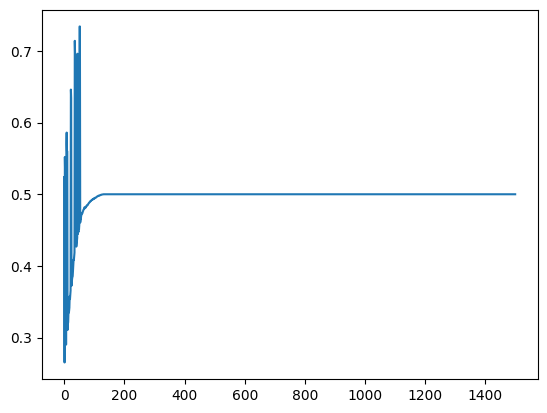

In [ ]:
plt.plot(range(len(max_fit)), max_fit)

## V2.0

In [2]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return np.ones(shape = len(survived[0])) / np.sum(survived, axis = 0)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    # Select top K fittest individuals and return N_OFFSPRINGS couple of individuals.
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree) -> list:
    fitness_list = []
    for individual in individuals:
        fitness_list.append(family_tree[tuple(individual)])
    
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))


def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child


# def two_cuts_xover(couple : tuple) -> list:
#     idx_1 = np.random.randint(1, len(couple[0]) - 2)
#     idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
#     return np.concatenate((couple[0][:idx_1], couple[1][idx_1:idx_2], couple[0][idx_2:]))

def two_cuts_xover(couple : tuple) -> list:
    idx_1 = np.random.randint(1, len(couple[0]) - 2)
    idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
    return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return two_cuts_xover(couple)

# Tests


##### `make_problem(1)`

- POP_SIZE = 10          
- N_OFFSPRINGS = 30      
- N_GENERATIONS = 200    
- TOP_K = 5              
- EPOCH = 10             
- N_CHAMPIONS = 2        
- SIZE = 1000             
- P_MUTATION = 0.2        
- N_ISLANDS = 1
- N_MIGRANTS = 5
- SIZE_VALHALLA = 3 * N_CHAMPIONS

In [5]:
POP_SIZE = 10                       # Number of parents
N_OFFSPRINGS = 30                   # Number of children
N_GENERATIONS = 200                 # Number of generations
TOP_K = 5                           # Number of parents from which generating the offsprings
EPOCH = 10                          # Number of generation to reintroduce all the champions
N_CHAMPIONS = 2                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 1                       # Number of different populations
N_MIGRANTS = 5                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_COMPLETE_MUTATION = 0.01

fitness = lab9_lib.make_problem(1)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [6]:
for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []

terminator = False
gen = 0
end = 0

while gen < N_GENERATIONS and not terminator:

    for island in globe.keys():
        if random() < 0.2 and len(globe.keys()) > 1:
             home = choice([isl for isl in globe.keys() if isl != island])
             if 'survived' in globe[home].keys() and len(globe[home]['survived']) != 0:
                 migrant = list(map(list, choices(globe[home]['survived'], k = N_MIGRANTS)))
                 migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                 globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                 globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        
        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        fitness_list = []
    
        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god)
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god

        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] == 1:
            terminator = True
            break
        
        # Every 10 generations, pick the champions and put them in a buffer, which, once full
        # (size equal to 3 * N_CHAMPIONS) keeps the most recent 2 * N_CHAMPIONS and substitutes
        # the oldest 1 * N_CHAMPIONS with the ones just computed.
        if gen % 10 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        # Every epoch, load the valhalla and compute the parents.
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], globe[island]['valhalla']))

        # Introduce some randomicity in order to inject champions from time to time.
        if random() < 0.8  and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})
        globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['survived'], family_tree)

    gen += 1

fitness.calls, globe['island0']['fit_god']

(3897, 1.0)

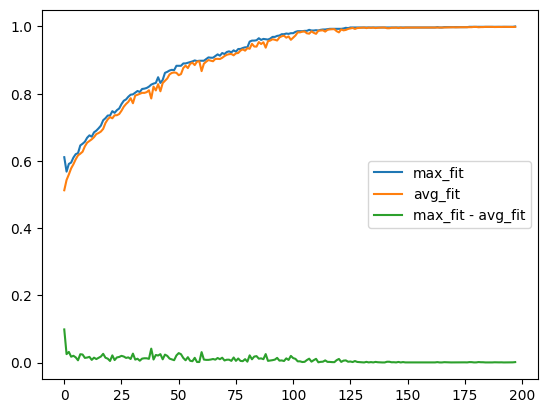

In [7]:
plt.plot(globe['island0']['max_fit'], label = 'max_fit')
plt.plot(globe['island0']['avg_fit'], label = 'avg_fit')
plt.plot(np.array(globe['island0']['max_fit']) - np.array(globe['island0']['avg_fit']), label = 'max_fit - avg_fit')
plt.legend()

In [985]:
mutated_fitness = list(map(fitness, globe['island0']['valhalla']))
ordered_mutated = [_ for _, x in sorted(zip(globe['island0']['valhalla'], mutated_fitness), key=lambda pair: pair[1], reverse=True)]

for sur in ordered_mutated:
    print(f"{''.join(str(g) for g in sur)}: {fitness(sur):.2%}")
print()
print(f"{''.join(str(g) for g in globe['island0']['god'])}: {globe['island0']['fit_god']:.2%}")

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111111111111110111111111111101111111111111101111111111111111111101111111111111111111111111111111111111

##### `make_problem(2)`

- POP_SIZE = 5                        
- N_OFFSPRINGS = 30                   
- N_GENERATIONS = 150  # If 1000 reach 1.0               
- TOP_K = 2                           
- EPOCH = 5                          
- N_CHAMPIONS = 1                    
- SIZE = 1000                        
- P_MUTATION = 0.2                   
- N_ISLANDS = 15                     
- N_MIGRANTS = 1                     
- SIZE_VALHALLA = 3 * N_CHAMPIONS    
- P_MIGRATION = 0.2
- P_COMPLETE_MUTATION = 0.2

---

- POP_SIZE = 5                        
- N_OFFSPRINGS = 30                   
- N_GENERATIONS = 1000  # If 1000 reach 1.0               
- TOP_K = 4                           
- EPOCH = 3                          
- N_CHAMPIONS = 1                    
- SIZE = 1000                        
- P_MUTATION = 0.2                   
- N_ISLANDS = 15                     
- N_MIGRANTS = 1                     
- SIZE_VALHALLA = 3 * N_CHAMPIONS    
- P_MIGRATION = 0.1
- P_COMPLETE_MUTATION = 0.2
- COS = False

In [4]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def get_distribution(survived : list) -> list:
    return (np.sum(survived, axis = 0) / (np.ones(shape = len(survived[0])) * POP_SIZE)).reshape(1, -1)


def compute_cosine(individual : list, distr : list) -> list:
    return cosine_similarity(np.array(individual).reshape(1, -1), distr.reshape(1, -1))


def compute_manhattan(individual : list, distr : list) -> list:
    return np.sum(np.abs(np.array(individual) - distr))


def mutate_all(individual : list) -> list:
    mutated_individual = copy.deepcopy(individual)
    for idx in range(len(mutated_individual)):
        if random() < P_COMPLETE_MUTATION:
            mutated_individual[idx] = 1 - mutated_individual[idx]
    return mutated_individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    # Select top K fittest individuals and return N_OFFSPRINGS couple of individuals.
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def roulette_selection_memoization(top_k : int, individuals : list, family_tree) -> list:
    fitness_list = []
    for individual in individuals:
        fitness_list.append(family_tree[tuple(individual)])
    
    parents = choices(individuals, weights=np.array(fitness_list)/sum(fitness_list), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))


def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child


# def two_cuts_xover(couple : tuple) -> list:
#     idx_1 = np.random.randint(1, len(couple[0]) - 2)
#     idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
#     return np.concatenate((couple[0][:idx_1], couple[1][idx_1:idx_2], couple[0][idx_2:]))

def n_cuts_xover(couple : tuple) -> list:
    if random() < 0.7:
        idx_1 = np.random.randint(1, len(couple[0]) - 2)
        idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))
    else:
        idx_1 = np.random.randint(1, len(couple[0]) / 2)
        idx_3 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
        idx_2 = np.random.randint(idx_1, idx_3)
        return np.concatenate((couple[1][:idx_1], couple[0][idx_1:idx_2], couple[1][idx_2:idx_3], couple[0][idx_3:]))

# [idx1, idx2, idx3]
def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return n_cuts_xover(couple)

In [242]:
POP_SIZE = 5                        # Number of parents
N_OFFSPRINGS = 40                   # Number of children
N_GENERATIONS = 1000                # Number of generations
TOP_K = 2                           # Number of parents from which generating the offsprings
EPOCH = 3                           # Number of generation to reintroduce all the champions
N_CHAMPIONS = 1                     # Number of champions that will be picked and sent each time to the population randomly
SIZE = 1000                         # Size of the genome
P_MUTATION = 0.2                    # Probability of a mutation        
N_ISLANDS = 15                      # Number of different populations
N_MIGRANTS = 1                      # Number of migrants from one island
SIZE_VALHALLA = 3 * N_CHAMPIONS     # Maximum number of champions
P_MIGRATION = 0.1
P_COMPLETE_MUTATION = 0.2
COS = False
fitness = lab9_lib.make_problem(2)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}
family_tree = {}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        individual = choices([0, 1], k=SIZE, weights=choices(([0.8, 0.2], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6]), k = 1)[0])
        globe[f'island{n}']['pop'].append(individual)

In [243]:
for island in globe.keys():
    family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['pop']})
    globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['pop'], family_tree)
    globe[island]['valhalla'] = np.zeros(shape = (SIZE_VALHALLA, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0
    globe[island]['migration'] = []

terminator = False
gen = 0
end = 0

while gen < N_GENERATIONS and not terminator:

    for island in globe.keys():
        print(island, gen)
        if random() < P_MIGRATION and len(globe.keys()) > 1:
             
             if np.array(['survived' in globe[isl].keys() for isl in globe.keys()]).all():
                # Compute the distribution of each island
                island_distr = {isl : get_distribution(globe[isl]['survived']) for isl in globe.keys()}
                # Compute the cosine similarity between distributions
                if COS:
                    island_cos = {isl : cosine_similarity(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    unnormalized_weights = 1 / np.array(list(island_cos.values()))
                    weights = unnormalized_weights / sum(unnormalized_weights)
                else:
                    island_manhattan = {isl : compute_manhattan(island_distr[isl], get_distribution(globe[island]['survived'])) for isl in island_distr.keys()}
                    weights = (np.array(list(island_manhattan.values())) ** 2) / (sum(np.array(list(island_manhattan.values())) ** 2))
                
                       
                home = choices([isl for isl in globe.keys()], weights=weights)[0]
                # home = choice([isl for isl in globe.keys() if isl != island])
                if 'valhalla' in globe[home].keys() and len(globe[home]['valhalla']) != 0:
                    migrant = list(map(list, choices(globe[home]['valhalla'], k = N_MIGRANTS)))
                    migrant_couple = [(migrant[i], globe[island]['parents'][rnd][0]) for i, rnd in zip(range(len(migrant)), np.random.randint(0, len(globe[island]['parents']), size = len(migrant)))]
                    globe[island]['parents'] = globe[island]['parents'] + migrant_couple
                    globe[island]['migration'].append(True)
        else:
            globe[island]['migration'].append(False)

        recombinated_offsprings = list(map(random_xover, globe[island]['parents']))
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        if random() < 0.1:
            zombie = []
            sur = globe[island]['mutated_offsprings']
            for s in sur:
                if random() < 0.2:
                    zombie.append(mutate_all(s))
            if len(zombie) != 0:
                globe[island]['mutated_offsprings'] = np.vstack((globe[island]['mutated_offsprings'], zombie))
                                   
        fitness_list = []

        for off in globe[island]['mutated_offsprings']:
            if tuple(off) not in family_tree.keys():
                family_tree[tuple(off)] = fitness(tuple(off))
            fitness_list.append(family_tree[tuple(off)])

        globe[island]['fit'] = np.array(fitness_list)
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        fitness_god = fitness(god)
        print(fitness_god)
        if fitness_god >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness_god

        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] > 0.85:
            terminator = True
            break
        
        # Every 10 generations, pick the champions and put them in a buffer, which, once full
        # (size equal to 3 * N_CHAMPIONS) keeps the most recent 2 * N_CHAMPIONS and substitutes
        # the oldest 1 * N_CHAMPIONS with the ones just computed.
        if gen % 10 == 0 and gen != 0:
            if end == 0 or end == SIZE_VALHALLA:
                count = 0
            start = count
            end = start + N_CHAMPIONS
            count += N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
        
        # Every epoch, load the valhalla and compute the parents.
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], globe[island]['valhalla']))

        # Introduce some randomicity in order to inject champions from time to time.
        if random() < 0.5  and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], choices(globe[island]['valhalla'], k = N_CHAMPIONS)))
        
        if random() < 0.1:
            globe[island]['survived'] = np.vstack((globe[island]['survived'], globe[island]['god']))

        family_tree.update({tuple(ind) : fitness(ind) if tuple(ind) not in family_tree.keys() else family_tree[tuple(ind)] for ind in globe[island]['survived']})
        globe[island]['parents'] = roulette_selection_memoization(TOP_K, globe[island]['survived'], family_tree)
        
    gen += 1
    

fitness.calls

island0 0
0.283
island1 0
0.2507
island2 0
0.2523
island3 0
0.4
island4 0
0.1895
island5 0
0.272
island6 0
0.416
island7 0
0.484
island8 0
0.516
island9 0
0.538
island10 0
0.2626
island11 0
0.2774
island12 0
0.612
island13 0
0.534
island14 0
0.2375
island0 1
0.2879
island1 1
0.259
island2 1
0.2689
island3 1
0.334
island4 1
0.19590000000000002
island5 1
0.272
island6 1
0.416
island7 1
0.488
island8 1
0.2832
island9 1
0.608
island10 1
0.2601
island11 1
0.594
island12 1
0.606
island13 1
0.592
island14 1
0.2387
island0 2
0.3025
island1 2
0.2616
island2 2
0.2753
island3 2
0.17830000000000001
island4 2
0.408
island5 2
0.276
island6 2
0.416
island7 2
0.2554
island8 2
0.2865
island9 2
0.606
island10 2
0.2592
island11 2
0.2888
island12 2
0.606
island13 2
0.2828
island14 2
0.2396
island0 3
0.3117
island1 3
0.267
island2 3
0.2711
island3 3
0.38
island4 3
0.408
island5 3
0.276
island6 3
0.416
island7 3
0.2525
island8 3
0.6
island9 3
0.608
island10 3
0.53
island11 3
0.2899
island12 3
0.606
island13

KeyboardInterrupt: 

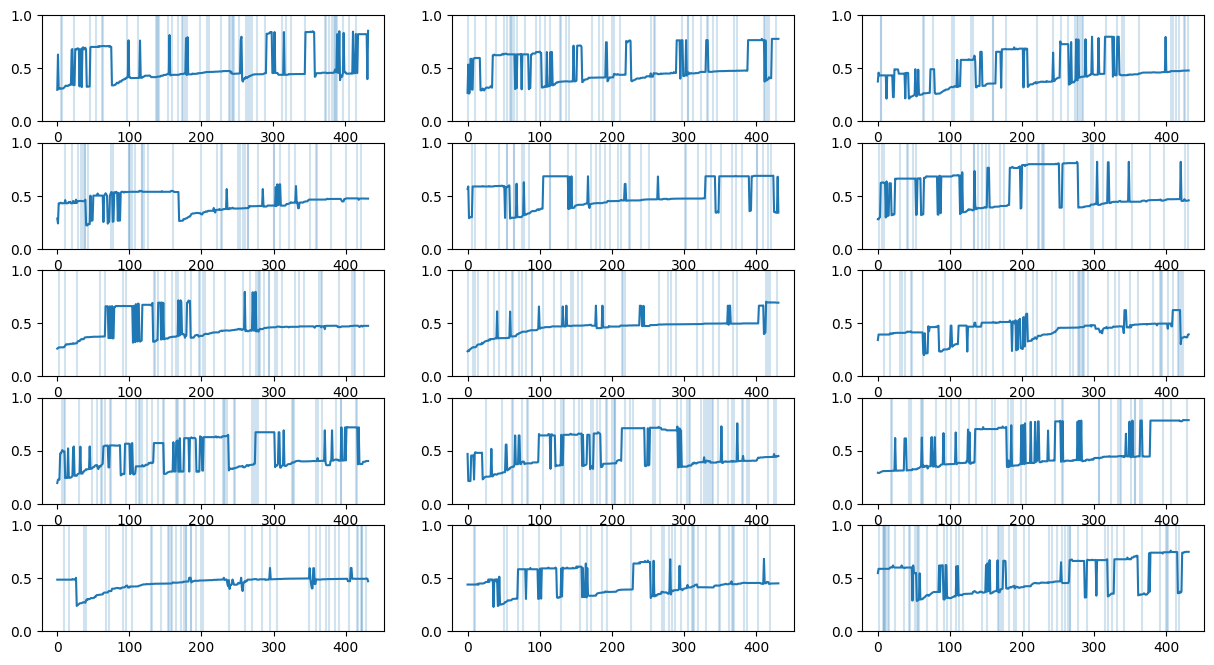

In [241]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
[ax[0, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island0']['migration'][idx] is True else 0 for idx in range(len(globe['island0']['migration']))] if element != 0]]
ax[0, 0].set_ylim(0, 1)

ax[0, 1].plot(globe['island1']['max_fit'])
[ax[0, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island1']['migration'][idx] is True else 0 for idx in range(len(globe['island1']['migration']))] if element != 0]]
ax[0, 1].set_ylim(0, 1)

ax[0, 2].plot(globe['island2']['max_fit'])
[ax[0, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island2']['migration'][idx] is True else 0 for idx in range(len(globe['island2']['migration']))] if element != 0]]
ax[0, 2].set_ylim(0, 1)

ax[1, 0].plot(globe['island3']['max_fit'])
[ax[1, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island3']['migration'][idx] is True else 0 for idx in range(len(globe['island3']['migration']))] if element != 0]]
ax[1, 0].set_ylim(0, 1)

ax[1, 1].plot(globe['island4']['max_fit'])
[ax[1, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island4']['migration'][idx] is True else 0 for idx in range(len(globe['island4']['migration']))] if element != 0]]
ax[1, 1].set_ylim(0, 1)

ax[1, 2].plot(globe['island5']['max_fit'])
[ax[1, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island5']['migration'][idx] is True else 0 for idx in range(len(globe['island5']['migration']))] if element != 0]]
ax[1, 2].set_ylim(0, 1)

ax[2, 0].plot(globe['island6']['max_fit'])
[ax[2, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island6']['migration'][idx] is True else 0 for idx in range(len(globe['island6']['migration']))] if element != 0]]
ax[2, 0].set_ylim(0, 1)

ax[2, 1].plot(globe['island7']['max_fit'])
[ax[2, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island7']['migration'][idx] is True else 0 for idx in range(len(globe['island7']['migration']))] if element != 0]]
ax[2, 1].set_ylim(0, 1)

ax[2, 2].plot(globe['island8']['max_fit'])
[ax[2, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island8']['migration'][idx] is True else 0 for idx in range(len(globe['island8']['migration']))] if element != 0]]
ax[2, 2].set_ylim(0, 1)

ax[3, 0].plot(globe['island9']['max_fit'])
[ax[3, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island9']['migration'][idx] is True else 0 for idx in range(len(globe['island9']['migration']))] if element != 0]]
ax[3, 0].set_ylim(0, 1)

ax[3, 1].plot(globe['island10']['max_fit'])
[ax[3, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island10']['migration'][idx] is True else 0 for idx in range(len(globe['island10']['migration']))] if element != 0]]
ax[3, 1].set_ylim(0, 1)

ax[3, 2].plot(globe['island11']['max_fit'])
[ax[3, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island11']['migration'][idx] is True else 0 for idx in range(len(globe['island11']['migration']))] if element != 0]]
ax[3, 2].set_ylim(0, 1)

ax[4, 0].plot(globe['island12']['max_fit'])
[ax[4, 0].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island12']['migration'][idx] is True else 0 for idx in range(len(globe['island12']['migration']))] if element != 0]]
ax[4, 0].set_ylim(0, 1)

ax[4, 1].plot(globe['island13']['max_fit'])
[ax[4, 1].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island13']['migration'][idx] is True else 0 for idx in range(len(globe['island13']['migration']))] if element != 0]]
ax[4, 1].set_ylim(0, 1)

ax[4, 2].plot(globe['island14']['max_fit'])
[ax[4, 2].axvline(x = value, alpha = 0.2) for value in [element for element in [idx if globe['island14']['migration'][idx] is True else 0 for idx in range(len(globe['island14']['migration']))] if element != 0]]
_ = ax[4, 2].set_ylim(0, 1)


In [1241]:
def mutate_bit(individual : list) -> list:
    if random() < P_MUTATION:    
        idx = np.random.randint(0, len(individual))
        mutated_individual = copy.deepcopy(individual)
        mutated_individual[idx] = 1 - mutated_individual[idx]
        return mutated_individual
    return individual


def roulette_selection(top_k : int, individuals : list, fitness : list) -> list:
    # Select top K fittest individuals and return N_OFFSPRINGS couple of individuals.
    parents = choices(individuals, weights=np.array(fitness)/sum(fitness), k=top_k)
    return choices([(parent1, parent2) for i, parent1 in enumerate(parents) for j, parent2 in enumerate(parents) if i != j], k=N_OFFSPRINGS)


def one_cut_xover(couple : tuple) -> list:
    idx = np.random.randint(1, len(couple[0]) - 1)
    return np.concatenate((couple[0][:idx], couple[1][idx:]))


def uniform_xover(couple : tuple) -> list:
    child = np.ndarray(shape = len(couple[0]), dtype=np.int16)
    for i in range(len(couple[0])):
        gene_giver = choice([couple[0], couple[1]])
        child[i] = int(gene_giver[i])
    return child


# def two_cuts_xover(couple : tuple) -> list:
#     idx_1 = np.random.randint(1, len(couple[0]) - 2)
#     idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
#     return np.concatenate((couple[0][:idx_1], couple[1][idx_1:idx_2], couple[0][idx_2:]))

def two_cuts_xover(couple : tuple) -> list:
    idx_1 = np.random.randint(1, len(couple[0]) - 2)
    idx_2 = np.random.randint(idx_1 + 1, len(couple[0]) - 1)
    return np.concatenate((couple[0][idx_1:idx_2], couple[1][:idx_1], couple[0][idx_2:]))

def random_xover(couple : tuple) -> list:
    flag = random()
    if flag < 0.33:
        return one_cut_xover(couple)
    elif 0.33 <= flag < 0.66:
        return uniform_xover(couple)
    elif 0.66 <= flag < 1:
        return two_cuts_xover(couple)
    
POP_SIZE = 20           # Number of parents
N_OFFSPRINGS = 50       # Number of children
N_GENERATIONS = 300     # Number of generations
TOP_K = 10              # Number of parents from which generating the offsprings
EPOCH = 10              # Number of generation to reintroduce the best fitting
N_CHAMPIONS = 12        # Number of champions that will rest in the Valhalla
SIZE = 1000             # Size of the genome
P_MUTATION = 0.1       # Probability of a mutation        
N_ISLANDS = 6
N_MIGRANTS = 3

fitness = lab9_lib.make_problem(10)

globe = {f'island{k}' : {'pop' : []} for k in range(N_ISLANDS)}

for n in range(N_ISLANDS):
    for _ in range(POP_SIZE):
        globe[f'island{n}']['pop'].append(choices([0, 1], k=SIZE, weights = np.random.random(size = 2)))

In [1242]:
for island in globe.keys():
    globe[island]['parents'] = roulette_selection(TOP_K, globe[island]['pop'], [fitness(ind) for ind in globe[island]['pop']])
    globe[island]['valhalla'] = np.empty(shape = ((EPOCH // 10) * N_CHAMPIONS, SIZE), dtype=np.int16)
    globe[island]['max_fit'] = []
    globe[island]['avg_fit'] = []
    globe[island]['fit_god'] = 0

terminator = False
gen = 0

while gen < N_GENERATIONS and not terminator:

    for island in globe.keys():

        print(island)
        if random() < 0.3:
             home = choice([isl for isl in globe.keys() if isl != island])
             if 'survived' in globe[home].keys() and len(globe[home]['survived']) != 0:
                 migrant = choices(globe[home]['survived'], k = N_MIGRANTS) 
                 globe[island]['parents'] + migrant

        recombinated_offsprings = map(random_xover, globe[island]['parents'])
        globe[island]['mutated_offsprings'] = np.array(list(map(mutate_bit, recombinated_offsprings)))
        globe[island]['fit'] = np.array(list(map(fitness, globe[island]['mutated_offsprings'])))
        globe[island]['survived'] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-POP_SIZE:]]
        
        globe[island]['max_fit'].append(max(globe[island]['fit']))
        god = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-1]]
        if fitness(god) >= globe[island]['fit_god']:
            globe[island]['god'] = god
            globe[island]['fit_god'] = fitness(god)

        globe[island]['avg_fit'].append(np.mean(globe[island]['fit']))
        
        if globe[island]['fit_god'] == 1:
            terminator = True
            break
        
        # Every 10 generations, pick the champions and put them in a buffer, which, once full
        # (size equal to 3 * N_CHAMPIONS) keeps the most recent 2 * N_CHAMPIONS and substitutes
        # the oldest 1 * N_CHAMPIONS with the ones just computed.
        if gen % 10 == 0 and gen != 0:
            start = (((gen - 1) % EPOCH) // 10) * N_CHAMPIONS
            end = (((gen - 1) % EPOCH) // 10) * N_CHAMPIONS + N_CHAMPIONS
            globe[island]['valhalla'][start:end, :] = globe[island]['mutated_offsprings'][np.argsort(globe[island]['fit'])[-N_CHAMPIONS:]]
            


        # Every epoch, load the valhalla and compute the parents.
        if gen % EPOCH == 0 and gen != 0:
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], globe[island]['valhalla']))

        # Introduce some randomicity in order to inject champions from time to time.
        if random() < 0.8 and (gen % EPOCH == 0 and gen != 0):
            globe[island]['survived'] = np.concatenate((globe[island]['survived'], choices(globe[island]['valhalla'], k = 4)))

        globe[island]['parents'] = roulette_selection(TOP_K, globe[island]['survived'], [fitness(ind) for ind in globe[island]['survived']])
        print(gen)

    gen += 1

island0
0
island1
0
island2
0
island3
0
island4
0
island5
0
island0
1
island1
1
island2
1
island3
1
island4
1
island5
1
island0
2
island1
2
island2
2
island3
2
island4
2
island5
2
island0
3
island1
3
island2
3
island3
3
island4
3
island5
3
island0
4
island1
4
island2
4
island3
4
island4
4
island5
4
island0
5
island1
5
island2
5
island3
5
island4
5
island5
5
island0
6
island1
6
island2
6
island3
6
island4
6
island5
6
island0
7
island1
7
island2
7
island3
7
island4
7
island5
7
island0
8
island1
8
island2
8
island3
8
island4
8
island5
8
island0
9
island1
9
island2
9
island3
9
island4
9
island5
9
island0
10
island1
10
island2
10
island3
10
island4
10
island5
10
island0
11
island1
11
island2
11
island3
11
island4
11
island5
11
island0
12
island1
12
island2
12
island3
12
island4
12
island5
12
island0
13
island1
13
island2
13
island3
13
island4
13
island5
13
island0
14
island1
14
island2
14
island3
14
island4
14
island5
14
island0
15
island1
15
island2
15
island3
15
island4
15
island5
15
isla

In [1243]:
fitness.calls

130811

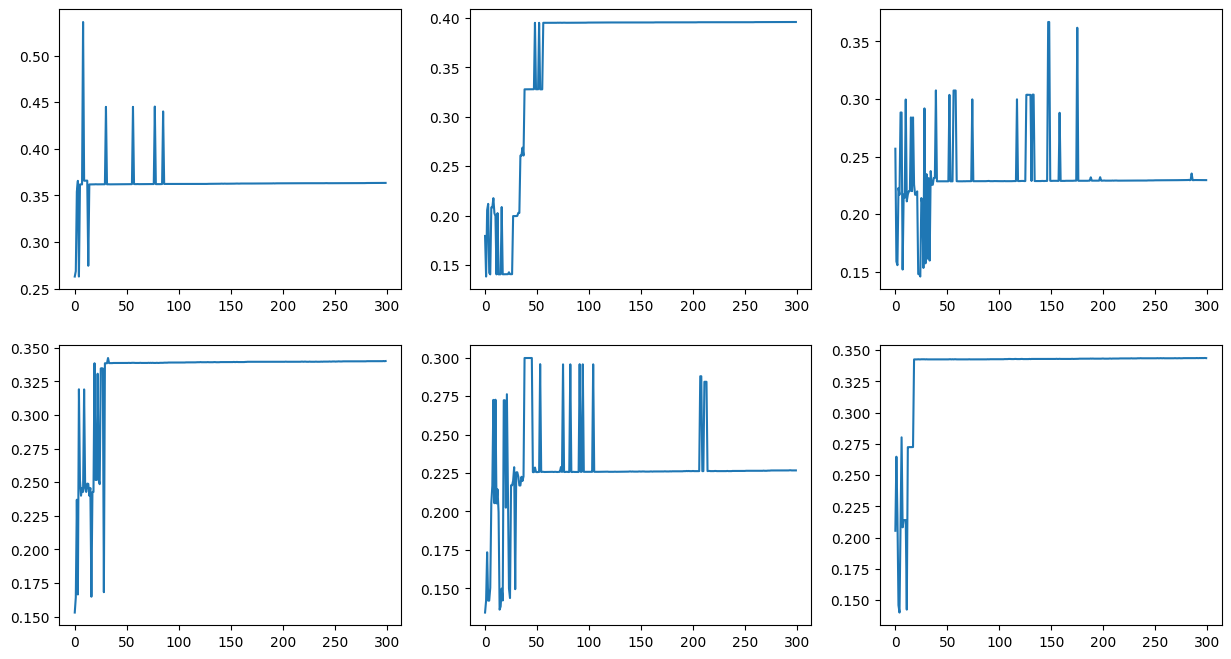

In [1244]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (15, 8))

ax[0, 0].plot(globe['island0']['max_fit'])
ax[0, 1].plot(globe['island1']['max_fit'])
ax[0, 2].plot(globe['island2']['max_fit'])
ax[1, 0].plot(globe['island3']['max_fit'])
ax[1, 1].plot(globe['island4']['max_fit'])
ax[1, 2].plot(globe['island5']['max_fit'])

In [1172]:
globe['island4']['god']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,